In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210310.h5ad'
adata = anndata.read_h5ad(fn_h5ad)
adata = adata[adata.obs['cell_quality'] == 'high']

adata.obs['dataset'] = adata.obs['platform'].replace({
    '10X': 'child',
    'plate': 'adult'
})
adata.obs['sick'] = adata.obs['Condition'].replace({
    'S_dengue': 'sick',
    'dengue': 'sick',
    'DWS': 'sick'
})
sc.pp.normalize_total(adata, target_sum=1e6) #normalize data to CPM (counts per million)
sc.pp.log1p(adata)
#'Age'：共16个病人，11个儿童，5个成年人
#'Condition'：S_dengue,dengue,Healthy,DWS
#'cell_subtype'：unknown, naive_B, CD14+CD16-mono, CD4-CD8+t, memory_B, CD16+CD14+mono, CD4+CD8-t, CD14-CD16+mono, CD4+CD8+t
#'cell_type'：NK_cells, B_cells, T_cells, Monocytes, Plasmablasts, pDCs, cDCs

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [2]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']

conditions = list(adata.obs['Condition'].astype('category').cat.categories)
datasets = list(adata.obs['dataset'].astype('category').cat.categories)
sicks = list(adata.obs['sick'].astype('category').cat.categories)
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

from collections import defaultdict
adata_dic = {}

for dataset in datasets:                                                                                                                          
    for condition in conditions:
        adata_dic[(condition, dataset)] = adata[adata.obs['Condition'] == condition][adata[adata.obs['Condition'] == condition].obs['dataset'] == dataset]
    for sick in sicks:
        adata_dic[(sick, dataset)] = adata[adata.obs['sick'] == sick][adata[adata.obs['sick'] == sick].obs['dataset'] == dataset]
    for cell_type in cell_types:
        adata_dic[(cell_type, dataset)] = adata[adata.obs['cell_type'] == cell_type][adata[adata.obs['cell_type'] == cell_type].obs['dataset'] == dataset]

In [3]:
adata_ch = adata_children[adata_children.obs['Condition'].isin(['Healthy', 'dengue', 'S_dengue'])]
adata_ch = adata_ch[adata_ch.obs['cell_type'].isin(['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs'])]
IDs = list(adata_ch.obs['ID'].astype('category').cat.categories)
IDs.remove('3_037_01')
IDs.remove('3_047_01')
a = list(set(IDs) - set(['3-037-01', '3-047-01']))
adata_ch_ID = adata_ch[adata_ch.obs['ID'].isin(IDs)]

from dengue_plots_functions import bar_ave_update, bar_ave, bar_exp, bar_ct

In [4]:
adata_ad = adata_adults[adata_adults.obs['Condition'].isin(['Healthy', 'dengue', 'S_dengue'])]
adata_ad = adata_ad[adata_ad.obs['cell_type'].isin(['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs'])]

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


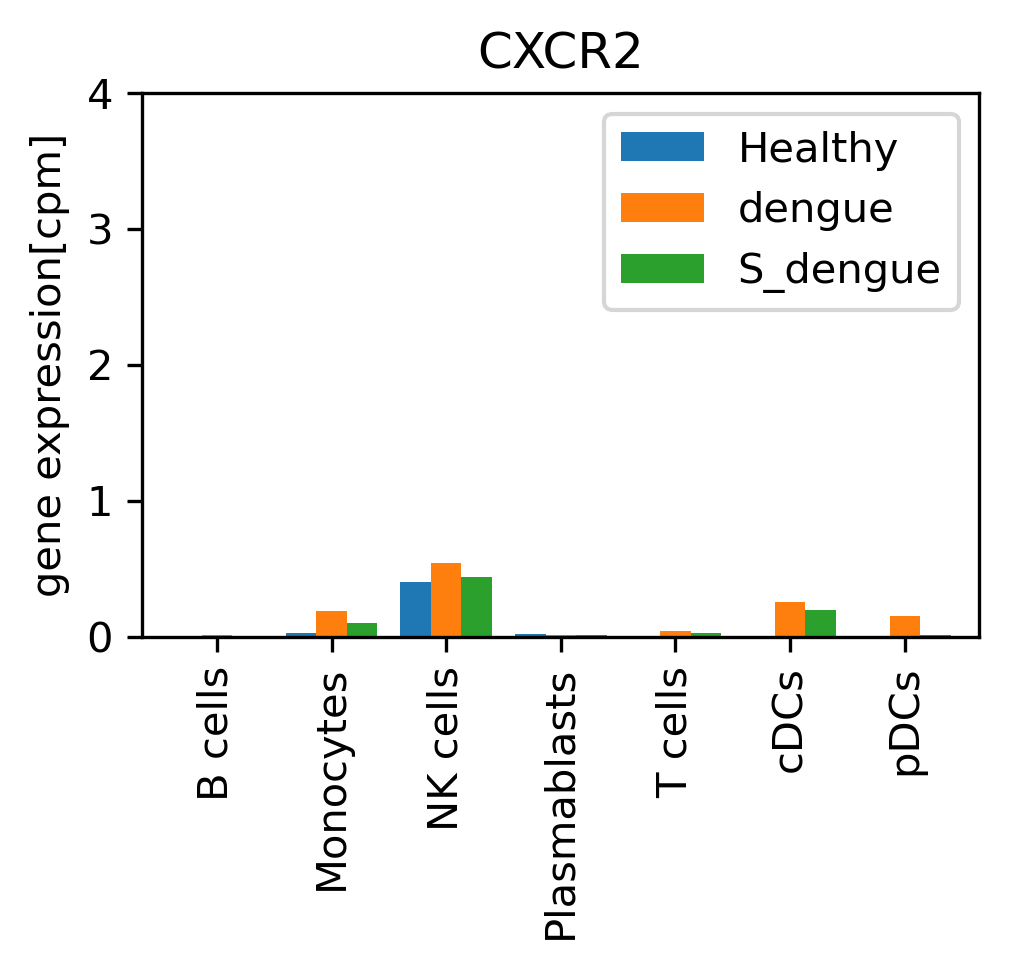

{'fig': <Figure size 1080x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'CXCR2'}, ylabel='gene expression[cpm]'>}

In [51]:
bar_ave(adata_ch_ID, 'CXCR2', 4)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


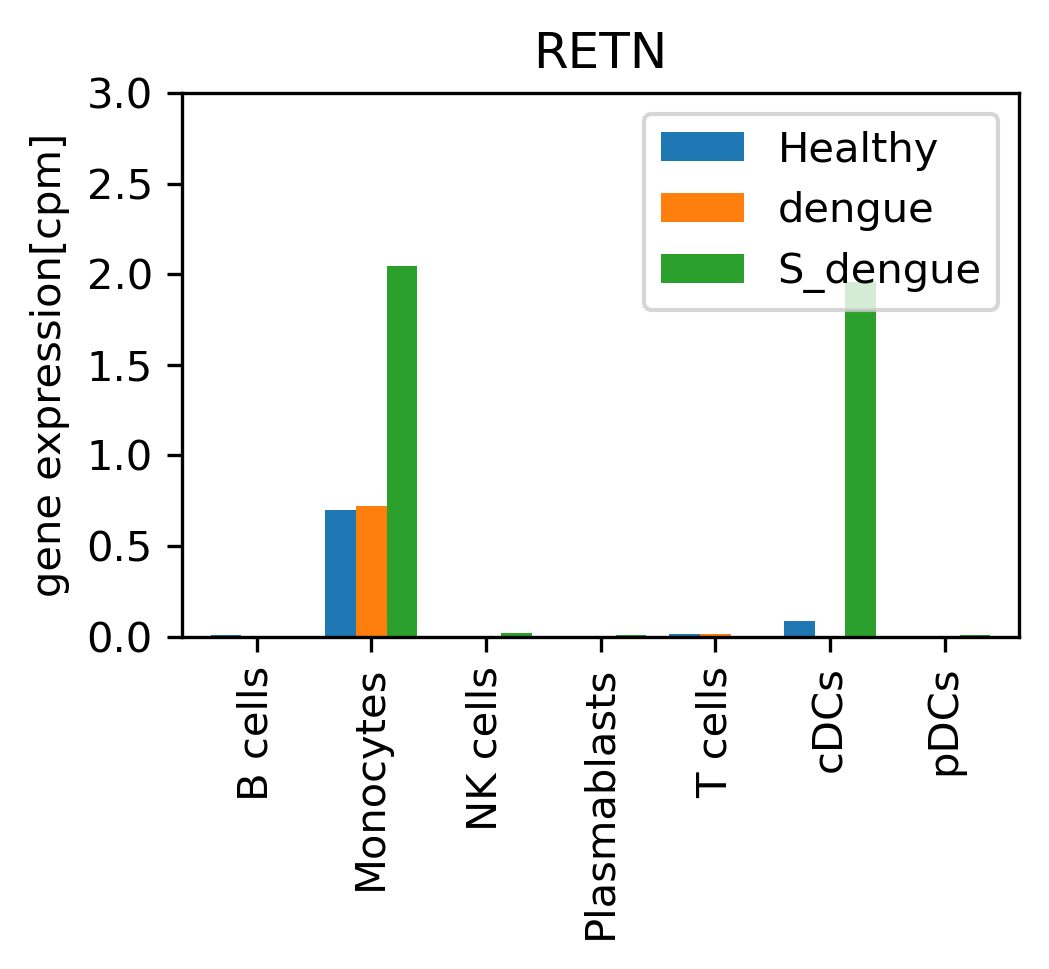

{'fig': <Figure size 1080x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'RETN'}, ylabel='gene expression[cpm]'>}

In [53]:
bar_ave(adata_ad, 'RETN', 3)

In [8]:
#bar_exp(adata_ch_ID, 'CXCL8', 1)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


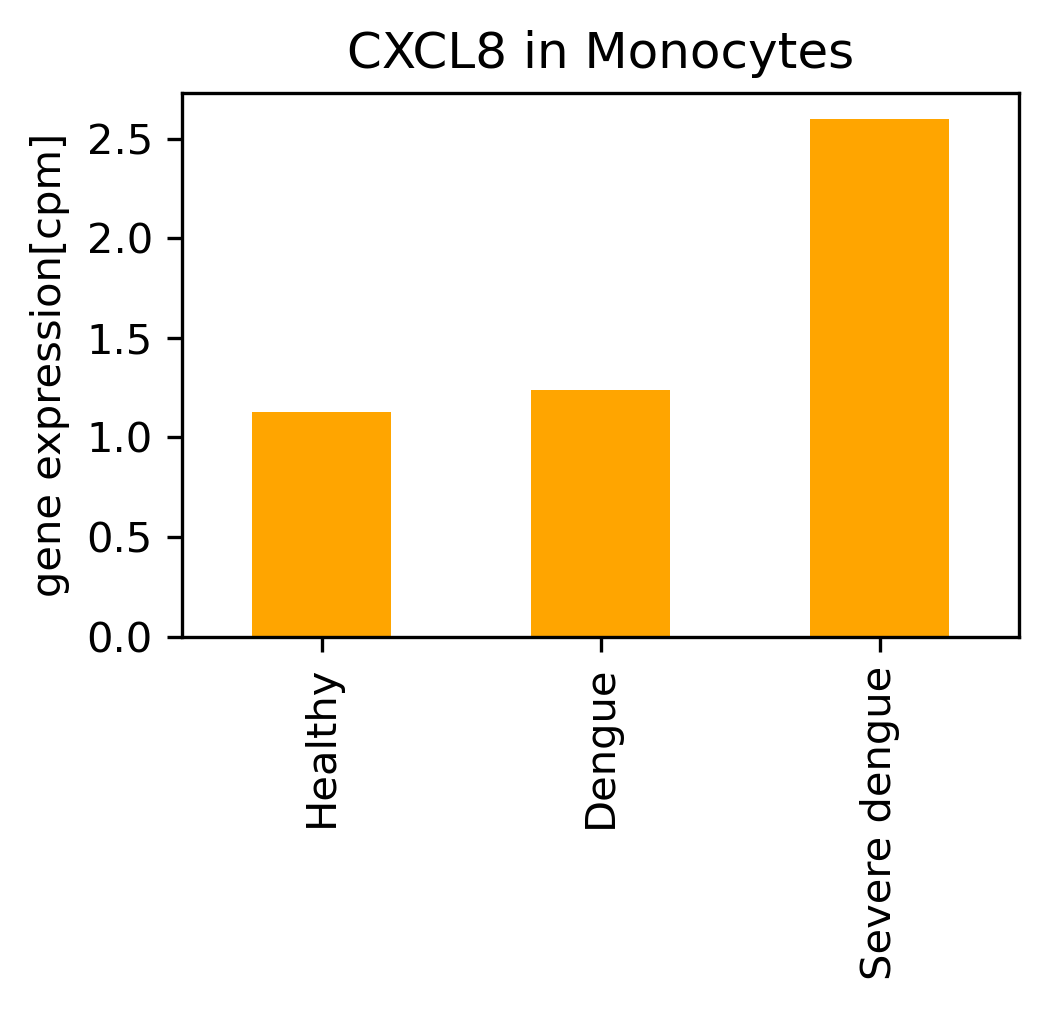

{'fig': <Figure size 1080x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'CXCL8 in Monocytes'}, ylabel='gene expression[cpm]'>}

In [6]:
bar_ct(adata_ch_ID, 'CXCL8', 'Monocytes')

In [7]:
from dengue_plots_functions import KS_test
KS_test(adata_ch, 'Monocytes', 'CXCL10')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'statistic': 0.17813030857641063, 'pvalue': 2.6375868829768972e-39}

In [47]:
def barplot_subct(adata, gene, ct, ylim):

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    #adata_ch = adata_children[adata_children.obs['Condition'].isin(['Healthy', 'dengue', 'S_dengue'])]
    
    cts = list((adata[adata.obs['cell_type'] == ct]).obs['cell_subtype'].astype('category').cat.categories)
    adata_ch = adata[adata.obs['cell_subtype'].isin(cts)]

    df = adata_ch.obs[['cell_subtype', 'Condition']].copy()
    df[gene] = adata_ch[:, gene].X.toarray()[:, 0]
    df['is_expressed'] = df[gene] > 0
    gby = df.groupby(['cell_subtype', 'Condition']).mean()
    # mean_expression = gby.loc['cell_type', 'CXCL10'] # cell_type
    # frac_expressed =  gby.loc[cell_type, 'is_expressed']

    fig, ax = plt.subplots(dpi=300, figsize=(3.6, 2.4))
    gby.unstack(1)[gene][['Healthy', 'dengue', 'S_dengue']].plot.bar(ax=ax, width=0.8)
    ax.set_xlabel(None)
    ax.set_ylabel('gene expression[cpm]', fontsize=10)
    ax.set_xticklabels(cts)
    ax.legend(labels=['Healthy', 'Dengue', 'Severe dengue'], loc='upper right', fontsize=8)
    ax.set_ylim([0, ylim])
    plt.xticks(fontsize=10)
    plt.title(gene)
    plt.legend(loc='upper right')
    plt.show()
    
    return {'fig': fig, 'ax': ax}

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


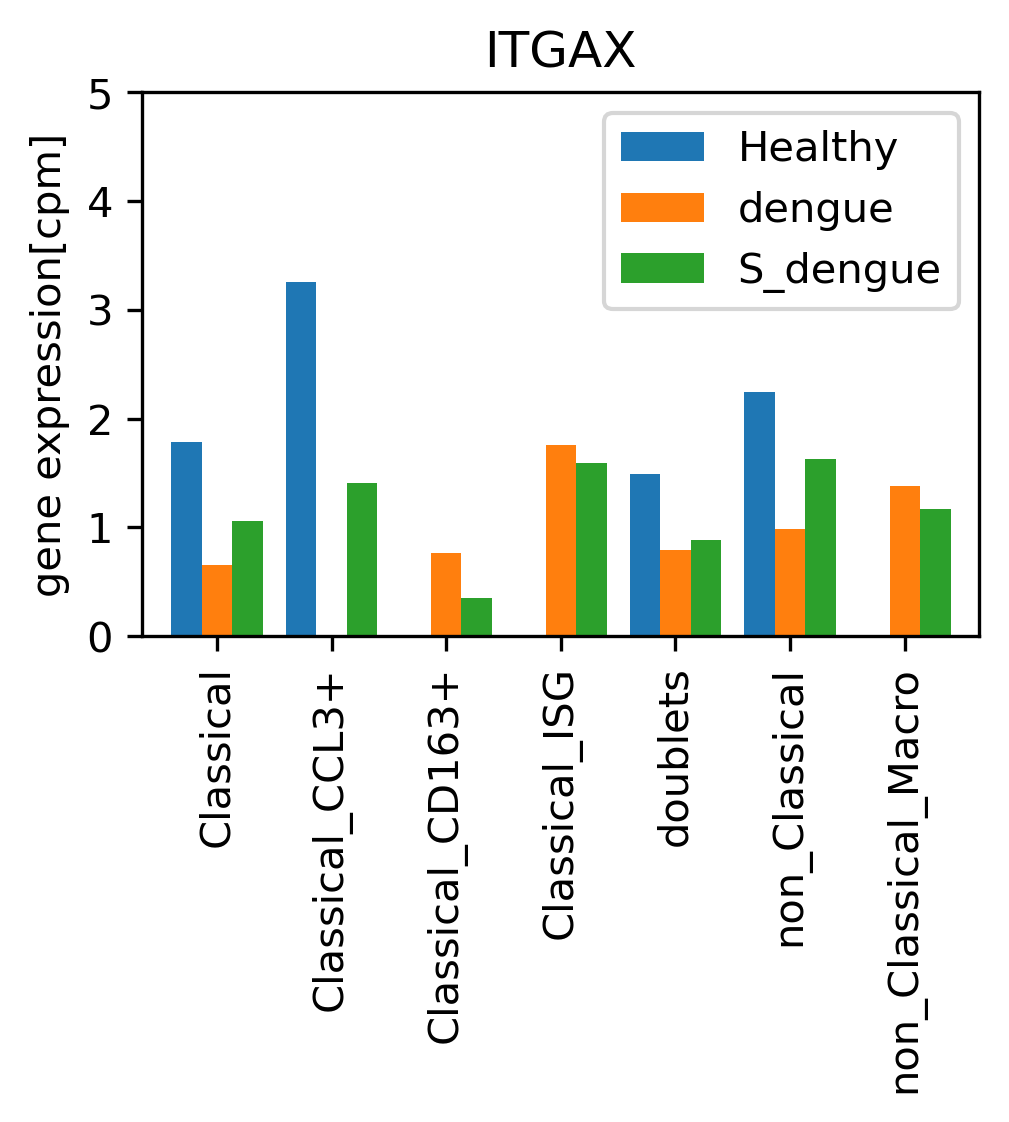

{'fig': <Figure size 1080x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'ITGAX'}, ylabel='gene expression[cpm]'>}

In [53]:
barplot_subct(adata_ch_ID, 'ITGAX', 'Monocytes', 5)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


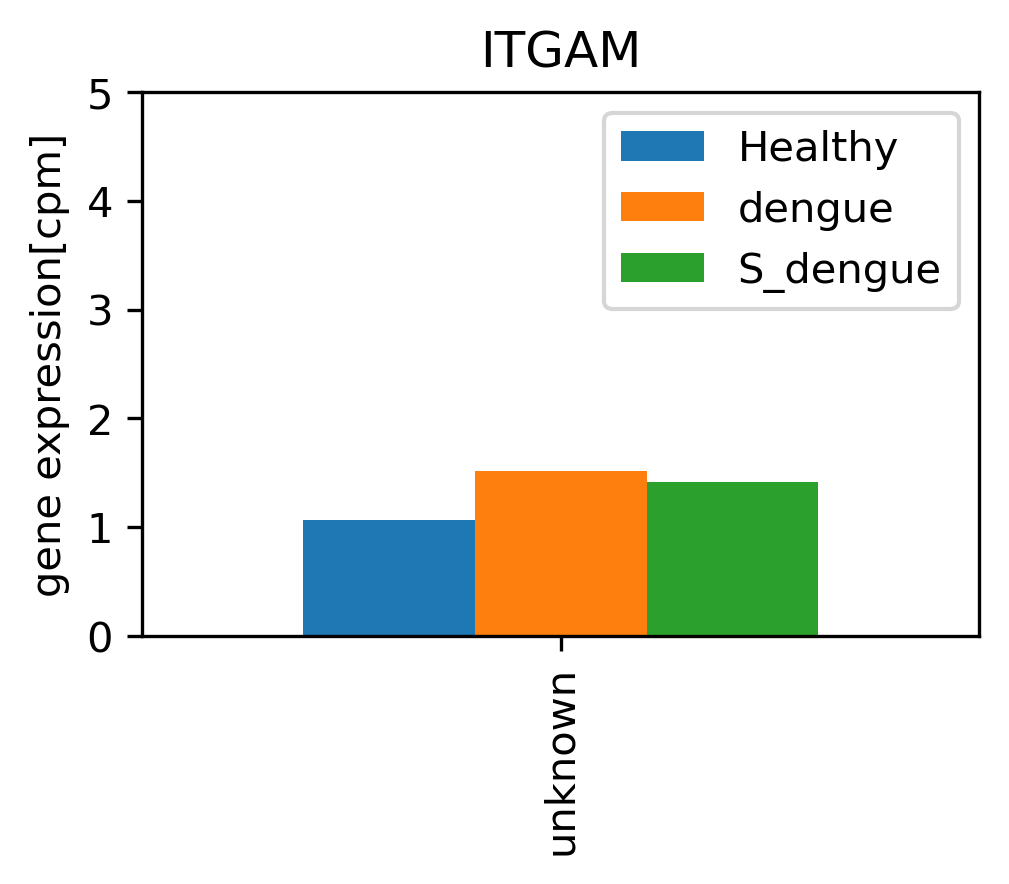

{'fig': <Figure size 1080x720 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'ITGAM'}, ylabel='gene expression[cpm]'>}

In [51]:
barplot_subct(adata_ad, 'ITGAM', 'Monocytes', 5)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<AxesSubplot:xlabel='Condition', ylabel='cell_type'>

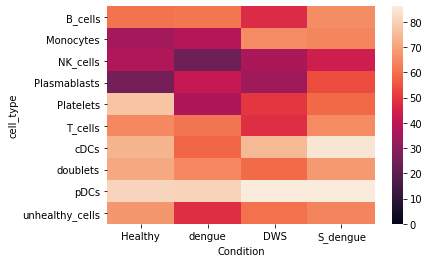

In [223]:
from dengue_plots_functions import heatmappy
heatmappy(adata_children, 'SELL', vmin=0)

In [10]:
adata_children[adata_children[:, 'FN1'].X > 0].obs[['cell_type', 'Condition', 'ID']].value_counts()

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


cell_type     Condition  ID      
Monocytes     S_dengue   1_002_01    340
Plasmablasts  S_dengue   1_002_01     19
Monocytes     S_dengue   1_075_01     16
                         5_030_01     10
                         5_193_01      7
              DWS        6_025_01      5
              Healthy    3_037_01      3
NK_cells      Healthy    3_047_01      2
T_cells       S_dengue   5_030_01      2
NK_cells      S_dengue   1_002_01      2
Monocytes     DWS        6_020_01      2
Plasmablasts  Healthy    3_037_01      1
T_cells       dengue     1_019_01      1
              S_dengue   1_002_01      1
              Healthy    3_047_01      1
cDCs          Healthy    3_037_01      1
T_cells       DWS        6_020_01      1
Plasmablasts  S_dengue   5_041_01      1
                         1_075_01      1
T_cells       S_dengue   5_041_01      1
B_cells       Healthy    3_037_01      1
Plasmablasts  DWS        6_028_01      1
                         6_025_01      1
                       

In [220]:
def cum_exp_ID(gene, ct):
    
    from matplotlib.pyplot import MultipleLocator
    D_IDs = list(adata_children[adata_children.obs['Condition'].isin(['dengue'])].obs['ID'].astype('category').cat.categories)
    SD_IDs = list(adata_children[adata_children.obs['Condition'].isin(['S_dengue'])].obs['ID'].astype('category').cat.categories)
    H_IDs = list(adata_children[adata_children.obs['Condition'].isin(['Healthy'])].obs['ID'].astype('category').cat.categories)
    IDs = D_IDs + SD_IDs + H_IDs

    cts = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
    adata_ch_ID = {(ID, ct): adata_children[adata_children.obs['ID'] == ID][adata_children[adata_children.obs['ID'] == ID].obs['cell_type']==ct] for ID in IDs for ct in cts}

    colors_D = sns.color_palette('hls', len(D_IDs))
    colors_SD = sns.color_palette('hls', len(SD_IDs))
    colors_H = sns.color_palette('hls', len(H_IDs))

    fig, ax = plt.subplots(3, 1, figsize=[3, 6], dpi=300, sharex=True, sharey=True)
    
    for i, ID in enumerate(H_IDs):
        gene_ID = adata_ch_ID[(ID, ct)][:, gene].X.toarray()[:, 0]
        x = np.sort(np.log10(0.1 + gene_ID))
        y = 1-np.linspace(0, 1, len(x))
        ax[0].plot(x, y, label=ID, lw=1.5, color = colors_H[i])    
    
    for i, ID in enumerate(D_IDs):
        gene_ID = adata_ch_ID[(ID, ct)][:, gene].X.toarray()[:, 0]
        x = np.sort(np.log10(0.1 + gene_ID))
        y = 1-np.linspace(0, 1, len(x))
        ax[1].plot(x, y, label=ID, lw=1.5, color = colors_D[i])

    for i, ID in enumerate(SD_IDs):
        gene_ID = adata_ch_ID[(ID, ct)][:, gene].X.toarray()[:, 0]
        x = np.sort(np.log10(0.1 + gene_ID))
        y = 1-np.linspace(0, 1, len(x))
        ax[2].plot(x, y, label=ID, lw=1.5, color = colors_SD[i])

    
    ax[2].set_xlabel('gene expression [log10(cpm+0.1)]',fontsize=10)
    plt.text(-1.5, 0.7, 'fract of cells expressing '+gene+' ≥ x',fontsize=10, rotation='vertical')
    
    
    for i, cd in zip([0, 1, 2], ['Healthy', 'Dengue', 'Severe dengue']):
        ax[i].legend(loc='upper left',bbox_to_anchor=(1,1),bbox_transform=ax[i].transAxes, fontsize=8)
        ax[i].set_title(cd, loc='right', fontsize=8)
        ax[i].yaxis.set_major_locator(MultipleLocator(0.2))
                     
    plt.show()
    
    return {'figure': fig, 'ax': ax}

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3

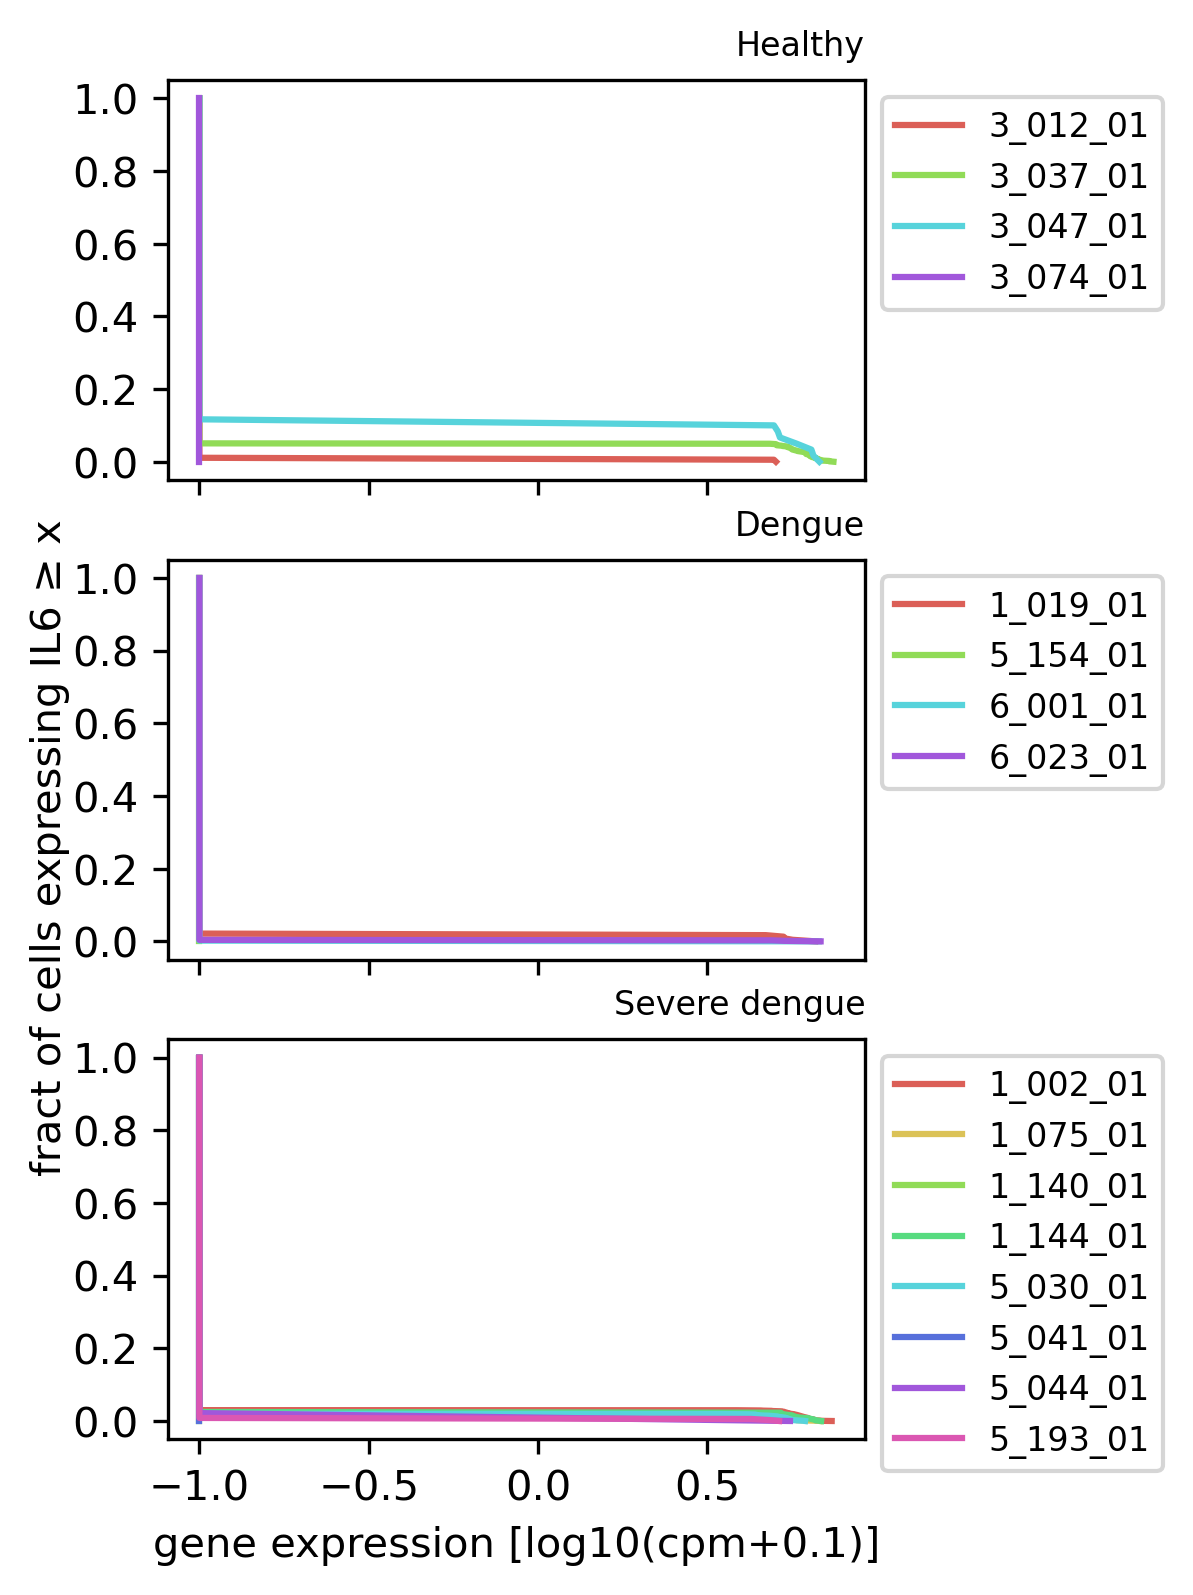

{'figure': <Figure size 900x1800 with 3 Axes>,
 'ax': array([<AxesSubplot:title={'right':'Healthy'}>,
        <AxesSubplot:title={'right':'Dengue'}>,
        <AxesSubplot:title={'right':'Severe dengue'}, xlabel='gene expression [log10(cpm+0.1)]'>],
       dtype=object)}

In [222]:
cum_exp_ID('IL6', 'Monocytes')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


<AxesSubplot:xlabel='cell_type', ylabel='Condition-ID'>

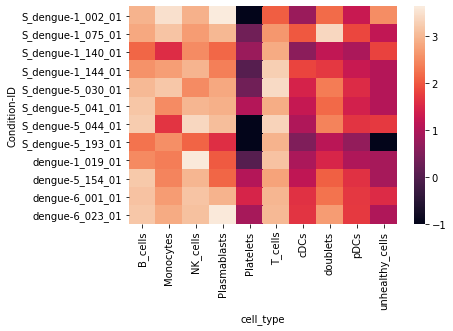

In [210]:
adatach_DENV = adata_children[adata_children.obs['Condition'].isin(['dengue', 'S_dengue'])]

use = adatach_DENV.obs[['cell_type', 'Condition', 'ID']].groupby(['cell_type', 'Condition', 'ID']).size().unstack(0).loc[[
    ('S_dengue', '1_002_01'),
    ('S_dengue', '1_075_01'),
    ('S_dengue', '1_140_01'),
    ('S_dengue', '1_144_01'),
    ('S_dengue', '5_030_01'),
    ('S_dengue', '5_041_01'),
    ('S_dengue', '5_044_01'),
    ('S_dengue', '5_193_01'),
    (  'dengue', '1_019_01'),
    (  'dengue', '5_154_01'),
    (  'dengue', '6_001_01'),
    (  'dengue', '6_023_01'),]]
sns.heatmap(np.log10(0.1 + use))

In [190]:
from numpy import * # 调用numpy所有函数
fn_int = '/home/yike/phd/dengue/data/interaction_unpacked_mouse.tsv'
interactions = pd.read_csv(fn_int, sep='\t')[['gene_name_a', 'gene_name_b']]
genes = np.unique(interactions)
adatag = adata[:, genes]

adatag_children = adatag[adatag.obs['dataset'] == 'child']

D_IDs = list(adata_children[adata_children.obs['Condition'].isin(['dengue'])].obs['ID'].astype('category').cat.categories)
SD_IDs = list(adata_children[adata_children.obs['Condition'].isin(['S_dengue'])].obs['ID'].astype('category').cat.categories)
IDs = list(adata_children.obs['ID'].astype('category').cat.categories)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']
from collections import defaultdict
adatag_ch_ct_cd_ID = {}
adatag_ch_ct_cd = {}
for cell_type in cell_types:
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition]
        for ID in IDs:
            adatag_ch_ct_cd_ID[(cell_type, condition, ID)] = adatag_ch_ct_cd[(cell_type, condition)][adatag_ch_ct_cd[(cell_type, condition)].obs['ID'] == ID]
            

gene_exp_ave = {}
for cell_type in cell_types:
    for condition in conditions:
        for ID in list(adata_children[adata_children.obs['Condition'].isin([condition])].obs['ID'].astype('category').cat.categories):
            exp = (adatag_ch_ct_cd_ID[(cell_type, condition, ID)].X > 0).toarray().mean(axis=0)
            gene_exp_ave[(cell_type, condition, ID)] = pd.DataFrame(exp, index=adatag_ch_ct_cd_ID[(cell_type, condition, ID)].var.index, columns=[['gene_expre']]).fillna(0)

In [187]:
# set 'IL6ST' in 'cDCs' at 'S_dengue' & 'dengue' as the example
from collections import defaultdict
gby = {}
for key in gene_exp_ave.keys():
    if (('cDCs' in key) & ('S_dengue' in key)) | (('cDCs' in key) & ('dengue' in key)):
        gby[(key[1], key[2])] = gene_exp_ave[key].loc['CTLA'][0].astype(np.int64)
        #gby['exp frac'].append(exp)
        #inx.append([key[1], key[2]])
    #gby = pd.DataFrame(gby, columns=['exp frac'], index=pd.Index(inx))
        

In [188]:
gby

{('S_dengue', '1_002_01'): 0,
 ('S_dengue', '1_075_01'): 0,
 ('S_dengue', '1_140_01'): 0,
 ('S_dengue', '1_144_01'): 0,
 ('S_dengue', '5_030_01'): 0,
 ('S_dengue', '5_041_01'): 0,
 ('S_dengue', '5_044_01'): 0,
 ('S_dengue', '5_193_01'): 0,
 ('dengue', '1_019_01'): 0,
 ('dengue', '5_154_01'): 0,
 ('dengue', '6_001_01'): 0,
 ('dengue', '6_023_01'): 0}

In [145]:
 gby.append(gene_exp_ave[key].loc['IL6ST'][0])
        inx.append([key[1], key[2]])
    gby = pd.DataFrame(gby, columns=['exp frac'], index=pd.Index(inx))
        

,exp frac


In [11]:
from dengue_plots_functions import vs_dot, vs_violin, vs_stacked_violin

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


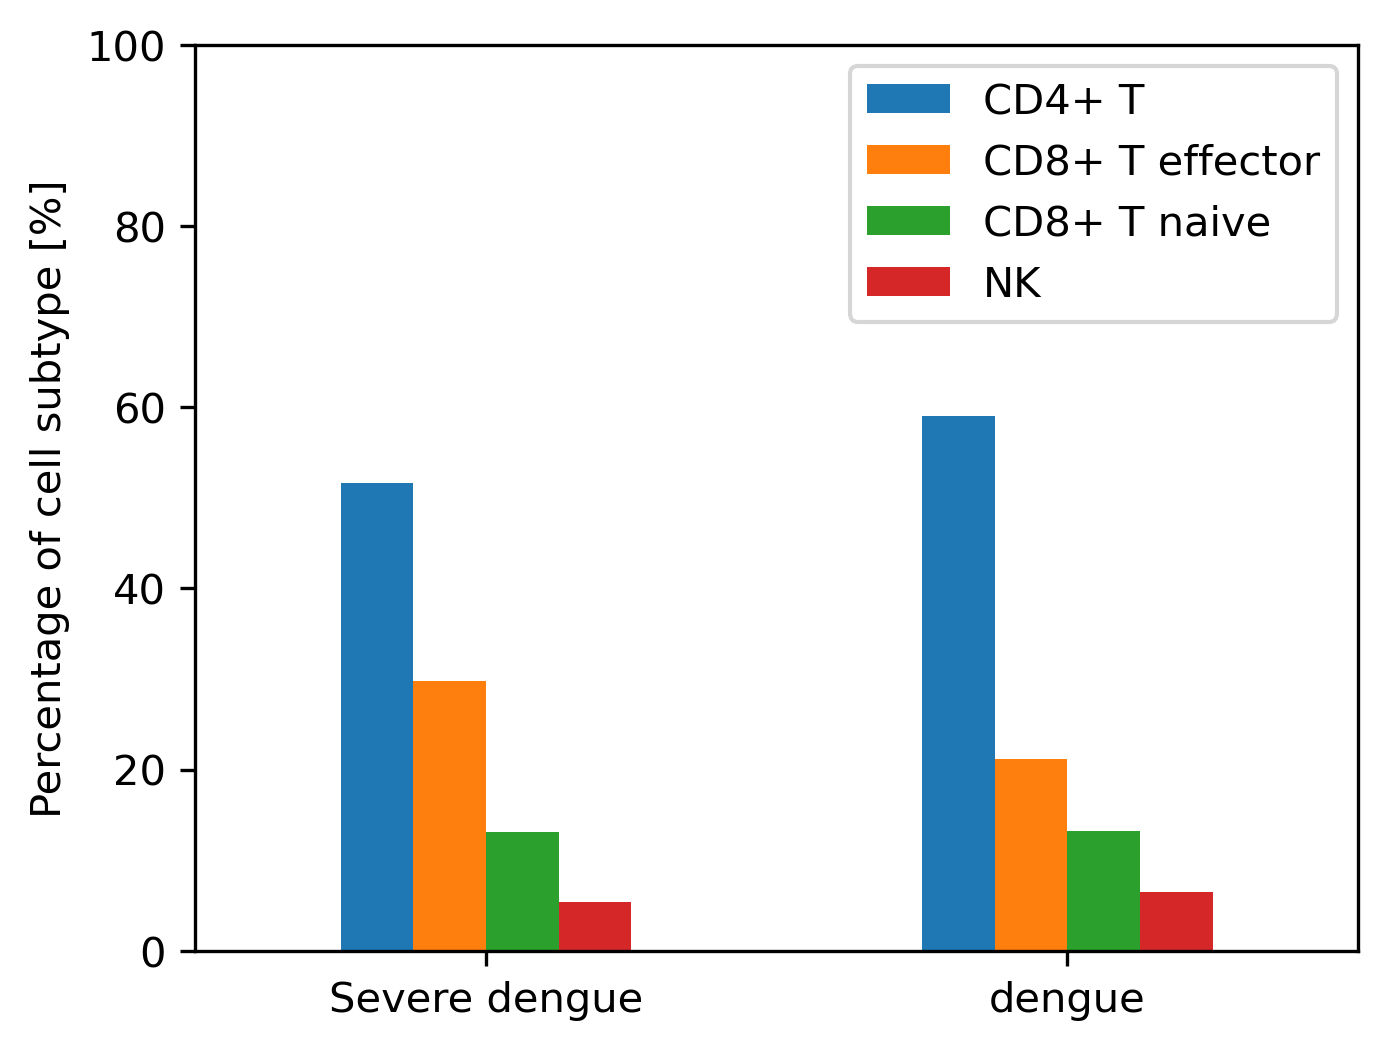

In [18]:
adata_children_T = adata_children[adata_children.obs['cell_type'] == 'T_cells']
n_subct = adata_children_T.obs[['Condition', 'cell_subtype']].groupby(['Condition', 'cell_subtype']).size().loc[['S_dengue', 'dengue']]
n_ct = adata_children_T.obs[['Condition', 'cell_type']].groupby(['Condition', 'cell_type']).size().loc[['S_dengue', 'dengue']]

subcts = list(n_subct.unstack().columns)
perct = pd.DataFrame([], columns=subcts)
for i in list(n_ct.unstack().index):
    perc = []
    for j, subct in enumerate(range(len(subcts))):
        perc.append((n_subct.unstack().loc[i][j])*100/(n_ct.unstack().loc[i][0]))
    perct.loc[i] = perc
    
fig, ax = plt.subplots(figsize=(5,4), dpi=300)
perct.plot.bar(ax=ax)
ax.set_ylim([0, 100])
ax.set_xticklabels(['Severe dengue', 'dengue'], fontsize=10, rotation=0)
ax.set_ylabel('Percentage of cell subtype [%]')
ax.legend(['CD4+ T', 'CD8+ T effector', 'CD8+ T naive', 'NK'])

/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38543 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20415 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 38543 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 20415 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0, flags=flags)


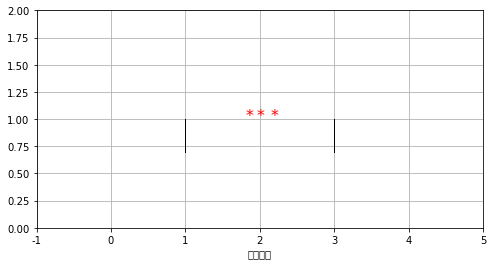

In [67]:
import numpy as np                 #使用import导入模块numpy，并简写成np
import matplotlib.pyplot as plt    #使用import导入模块matplotlib.pyplot，并简写成plt
plt.figure(figsize=(8,4))          #设置绘图对象的宽度和高度
from PIL import Image
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题   

x1 = [1, 1]
y1 = [0.7, 1.0]
plt.plot(x1,y1,color="black",linewidth=1)

x2 = [1, 3]
y2 = [1, 1]
plt.plot(x2,y2,color="black",linewidth=1)

x3 = [3, 3]
y3 = y1
plt.plot(x3,y3,color="black",linewidth=1)

x0 = 2
y0=1
plt.annotate(r'$***$', xy=(x0, y0), xycoords='data', xytext=(-15, +1),
             textcoords='offset points', fontsize=16,color="red")

plt.ylim(0,2)             #使用plt.ylim设置y坐标轴范围
plt.xlim(-1,5)
plt.xlabel("随便画画")         #用plt.xlabel设置x坐标轴名称
'''设置图例位置'''
plt.grid(True)
plt.show()

In [200]:
a = [0, 1, 2,3,4]

In [202]:
a[3:]

[3, 4]